# Installations

In [ ]:
# !pip install contextualized-topic-models==2.3.0
# !pip install datasets
# !pip install pyldavis
# !pip install bertopic

In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords as stop_words
from datasets import load_dataset
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import string
from gensim.utils import deaccent
import warnings
from sentence_transformers import SentenceTransformer
import scipy.sparse
from contextualized_topic_models.datasets.dataset import CTMDataset
from sklearn.preprocessing import OneHotEncoder
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.models.ctm import ZeroShotTM
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
from bertopic import BERTopic
from sklearn.model_selection import train_test_split

/home/arnav/.conda/envs/BERTopic_1/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/arnav/.conda/envs/BERTopic_1/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/arnav/.conda/envs/BERTopic_1/lib/python3.11/site-packages/umap/d

In [7]:
# import pandas as pd
# import sqlalchemy

# db = sqlalchemy.engine.url.URL(drivername='mysql',
#                                host='127.0.0.1',
#                                database='comp_topic_models',
#                                query={'read_default_file': '~/.my.cnf', 'charset': 'utf8mb4'})

# engine = sqlalchemy.create_engine(db)
# twitter_df = pd.read_sql('SELECT * FROM twitter_pol_dedup', engine)
# twitter_df.to_csv('dlatk/twitter/twitter_df.csv')

In [37]:
# twitter_df = pd.read_csv('dlatk/twitter/twitter_df.csv')
# twitter_df['review_body'] = twitter_df['message']

<ipython-input-37-444cd106907e>:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  twitter_df = pd.read_csv('dlatk/twitter/twitter_df.csv')


In [40]:
# arr = sklearn.utils.shuffle(np.arange(len(twitter_df)), random_state=42)[0:int(len(twitter_df) * 0.01)]
# twitter_temp = twitter_df.iloc[arr].reset_index(drop=True)
# twitter_temp.reset_index(drop=True, inplace=True)
# twitter_temp = twitter_temp[['message', 'age']]
# twitter_temp = twitter_temp.dropna()
# twitter_temp

,message,age
2,I'm just not myself today,22.0
3,<USER> oh don't worry. That's just my river of...,19.0
4,New Hampshire goes to #Obama! #VeryNice,35.0
6,"<USER> They're ""brave"" enough to illegally kil...",68.0
7,"<USER> Coach Pagano. Life long Horseshoe fan, ...",33.0
...,...,...
65528,RT <USER>: #UCCShooting witness: Shooter asked...,58.0
65529,RT <USER>: Austinu2019s top 10 Instagram accou...,31.0
65530,Didn't get into the college I wanted\nKinda sa...,19.0
65534,when the booty thick <URL>,22.0


# Variables Changing

In [17]:
is_multi = False
is_combined = not is_multi
perc = 0.10 # 10% of dataset

nltk.download('stopwords')

language = 'en' if is_combined else 'all_languages'
stopwords = list(stop_words.words('english')) if is_combined else list(stop_words.words(stop_words.fileids())) # from every language
embedding_model = 'paraphrase-distilroberta-base-v2' if is_combined else 'paraphrase-multilingual-mpnet-base-v2'

text_column = 'text'
label_column = 'label'

num_epochs_ctm = 25
num_topics = 25
num_topics_word = 500

[nltk_data] Downloading package stopwords to /home/arnav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset

In [ ]:
# download the whole dataset, store it in 

# cd 
# cd /sandata
# cd arnav
# so save under /sandata/arnav

In [3]:
dataset = load_dataset('mteb/amazon_reviews_multi', language)

Found cached dataset amazon_reviews_multi (/home/arnav/.cache/huggingface/datasets/mteb___amazon_reviews_multi/en/1.0.0/61154b14772a2d73f3554caa8f5bd1fec4b65ec64f70bb93fa9fec6b038a4355)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
def data(part):
  data = dataset[part].to_pandas()
  review_body = list(data[text_column])
  return data, review_body

In [5]:
train, review_body = data('train')
test, review_body_test = data('test')
validation, review_body_validation = data('validation')

In [6]:
def make_review_body(data, perc):
  arr = sklearn.utils.shuffle(np.arange(len(data)), random_state=42)[0:int(len(data) * perc)]
  temp = data.iloc[arr].reset_index(drop=True)
  review_body = list(temp[text_column])
  temp.reset_index(drop=True, inplace=True)
  temp = temp.rename(columns = {'index': 'message_id', text_column: 'message'})
  return temp, review_body

In [7]:
temp_train, review_body = make_review_body(train, perc)
temp_test, test_review_body = make_review_body(test, 1)
temp_validation, validation_review_body = make_review_body(validation, 1)

In [ ]:
twitter_df

In [42]:
# for twitter only
from sklearn.model_selection import train_test_split
temp_train, temp_test, review_body, test_review_body = train_test_split(twitter_temp.drop(columns = ['message']), twitter_temp['message'], test_size = 0.20, random_state = 42)
review_body = list(review_body)
test_review_body = list(test_review_body)

In [84]:
# sum = 0
# for i in temp_train['review_id']:
#   print(i in list(train['review_id']))

In [8]:
len(temp_test), len(temp_train)

(5000, 20000)

In [9]:
len(test), len(temp_test), len(train), len(temp_train)

(5000, 5000, 200000, 20000)

## SQL to run DLATK Mallet LDA

In [8]:
# temp_train = pd.concat([temp_train, temp_test])
# review_body = pd.concat([pd.Series(review_body), pd.Series(test_review_body)])

# temp_train_to_save = pd.concat([temp_train, temp_test])[['message_id', 'message']]
# temp_test_to_save = temp_test[['message_id', 'message']]
# temp_validation_to_save = temp_validation[['message_id', 'message']]

In [9]:
# temp_train_to_save.to_csv('amazon_multi_train_ten.csv')
# temp_test_to_save.to_csv('amazon_multi_test_ten.csv')
# temp_validation_to_save.to_csv('amazon_multi_validation_ten.csv')

# temp_train_to_save.to_csv('amazon_eng_train_ten.csv')
# temp_test_to_save.to_csv('amazon_eng_test_ten.csv')
# temp_validation_to_save.to_csv('amazon_eng_validation_ten.csv')

In [10]:
# import pandas as pd
# import sqlalchemy

# temp_train_from_save = pd.read_csv('amazon_eng_train_ten.csv')
# temp_train_from_save = temp_train_from_save[['message_id', 'message']]

# # temp_test_from_save = pd.read_csv('amazon_eng_test_ten.csv')
# # temp_test_from_save = temp_test_from_save[['message_id', 'message']]

# # temp_validation_from_save = pd.read_csv('amazon_eng_validation_ten.csv')
# # temp_validation_from_save = temp_validation_from_save[['message_id', 'message']]

# db = sqlalchemy.engine.url.URL(drivername='mysql', host='127.0.0.1', database='arnav', query={'read_default_file': '~/.my.cnf', 'charset':'utf8mb4'})
# engine = sqlalchemy.create_engine(db)

# temp_train_from_save.to_sql('amazon_eng_train_ten', engine, if_exists='replace', index=False) 
# # temp_test_from_save.to_sql('amazon_eng_test_ten', engine, if_exists='replace', index=False) 
# # temp_validation_from_save.to_sql('amazon_eng_validation_ten', engine, if_exists='replace', index=False) 

# Preprocessing


In [8]:
class WhiteSpacePreprocessingStopwords():
    """
    Provides a very simple preprocessing script that filters infrequent tokens from text
    """

    def __init__(self, documents, stopwords_list=None, vocabulary_size=2000, max_df=1.0, min_words=1,
                 remove_numbers=True):
        """

        :param documents: list of strings
        :param stopwords_list: list of the stopwords to remove
        :param vocabulary_size: the number of most frequent words to include in the documents. Infrequent words will be discarded from the list of preprocessed documents
        :param max_df : float or int, default=1.0
        When building the vocabulary ignore terms that have a document
        frequency strictly higher than the given threshold (corpus-specific
        stop words).
        If float in range [0.0, 1.0], the parameter represents a proportion of
        documents, integer absolute counts.
        This parameter is ignored if vocabulary is not None.
        :param min_words: int, default=1. Documents with less words than the parameter
        will be removed
        :param remove_numbers: bool, default=True. If true, numbers are removed from docs
        """
        self.documents = documents
        if stopwords_list is not None:
            self.stopwords = set(stopwords_list)
        else:
            self.stopwords = []

        self.vocabulary_size = vocabulary_size
        self.max_df = max_df
        self.min_words = min_words
        self.remove_numbers = remove_numbers

    def preprocess(self):
        """
        Note that if after filtering some documents do not contain words we remove them. That is why we return also the
        list of unpreprocessed documents.

        :return: preprocessed documents, unpreprocessed documents and the vocabulary list
        """
        preprocessed_docs_tmp = self.documents
        preprocessed_docs_tmp = [deaccent(doc.lower()) for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [doc.translate(
            str.maketrans(string.punctuation, ' ' * len(string.punctuation))) for doc in preprocessed_docs_tmp]
        if self.remove_numbers:
            preprocessed_docs_tmp = [doc.translate(str.maketrans("0123456789", ' ' * len("0123456789")))
                                     for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if len(w) > 0 and w not in self.stopwords])
                                 for doc in preprocessed_docs_tmp]

        vectorizer = CountVectorizer(max_features=self.vocabulary_size, max_df=self.max_df)
        vectorizer.fit_transform(preprocessed_docs_tmp)
        temp_vocabulary = set(vectorizer.get_feature_names_out())

        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if w in temp_vocabulary])
                                 for doc in preprocessed_docs_tmp]

        preprocessed_docs, unpreprocessed_docs, retained_indices = [], [], []
        for i, doc in enumerate(preprocessed_docs_tmp):
            if len(doc) > 0 and len(doc) >= self.min_words:
                preprocessed_docs.append(doc)
                unpreprocessed_docs.append(self.documents[i])
                retained_indices.append(i)

        vocabulary = list(set([item for doc in preprocessed_docs for item in doc.split()]))

        return preprocessed_docs, unpreprocessed_docs, vocabulary, retained_indices


# TopicModelDataPreparation

In [9]:
def get_bag_of_words(data, min_length):
    """
    Creates the bag of words
    """
    vect = [np.bincount(x[x != np.array(None)].astype('int'), minlength=min_length)
            for x in data if np.sum(x[x != np.array(None)]) != 0]

    vect = scipy.sparse.csr_matrix(vect)
    return vect


def bert_embeddings_from_file(text_file, sbert_model_to_load, batch_size=200, max_seq_length=None):
    """
    Creates SBERT Embeddings from an input file, assumes one document per line
    """

    model = SentenceTransformer(sbert_model_to_load)

    if max_seq_length is not None:
        model.max_seq_length = max_seq_length

    with open(text_file, encoding="utf-8") as filino:
        texts = list(map(lambda x: x, filino.readlines()))

    check_max_local_length(max_seq_length, texts)

    return np.array(model.encode(texts, show_progress_bar=True, batch_size=batch_size))


def bert_embeddings_from_list(texts, sbert_model_to_load, batch_size=200, max_seq_length=None):
    """
    Creates SBERT Embeddings from a list
    """
    model = SentenceTransformer(sbert_model_to_load)

    if max_seq_length is not None:
        model.max_seq_length = max_seq_length

    check_max_local_length(max_seq_length, texts)

    return np.array(model.encode(texts, show_progress_bar=True, batch_size=batch_size))


def check_max_local_length(max_seq_length, texts):
    max_local_length = np.max([len(t.split()) for t in texts])
    if max_local_length > max_seq_length:
        warnings.simplefilter('always', DeprecationWarning)
        warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "
                      f"truncates to {max_seq_length} tokens.")


class TopicModelDataPreparation:

    def __init__(self, contextualized_model=None, show_warning=True, max_seq_length=128):
        self.contextualized_model = contextualized_model
        self.vocab = []
        self.id2token = {}
        self.vectorizer = None
        self.label_encoder = None
        self.show_warning = show_warning
        self.max_seq_length = max_seq_length

    def load(self, contextualized_embeddings, bow_embeddings, id2token, labels=None):
        return CTMDataset(
            X_contextual=contextualized_embeddings, X_bow=bow_embeddings, idx2token=id2token, labels=labels)

    def fit(self, text_for_contextual, text_for_bow, labels=None, custom_embeddings=None):
        """
        This method fits the vectorizer and gets the embeddings from the contextual model

        :param text_for_contextual: list of unpreprocessed documents to generate the contextualized embeddings
        :param text_for_bow: list of preprocessed documents for creating the bag-of-words
        :param custom_embeddings: np.ndarray type object to use custom embeddings (optional).
        :param labels: list of labels associated with each document (optional).
        """

        if custom_embeddings is not None:
            assert len(text_for_contextual) == len(custom_embeddings)

            if text_for_bow is not None:
                assert len(custom_embeddings) == len(text_for_bow)

            if type(custom_embeddings).__module__ != 'numpy':
                raise TypeError("contextualized_embeddings must be a numpy.ndarray type object")

        if text_for_bow is not None:
            assert len(text_for_contextual) == len(text_for_bow)

        if self.contextualized_model is None and custom_embeddings is None:
            raise Exception("A contextualized model or contextualized embeddings must be defined")

        # TODO: this count vectorizer removes tokens that have len = 1, might be unexpected for the users
        self.vectorizer = CountVectorizer()

        train_bow_embeddings = self.vectorizer.fit_transform(text_for_bow)

        # if the user is passing custom embeddings we don't need to create the embeddings using the model

        if custom_embeddings is None:
            train_contextualized_embeddings = bert_embeddings_from_list(
                text_for_contextual, sbert_model_to_load=self.contextualized_model, max_seq_length=self.max_seq_length)
        else:
            train_contextualized_embeddings = custom_embeddings
        self.vocab = self.vectorizer.get_feature_names_out()
        self.id2token = {k: v for k, v in zip(range(0, len(self.vocab)), self.vocab)}

        if labels:
            self.label_encoder = OneHotEncoder()
            encoded_labels = self.label_encoder.fit_transform(np.array([labels]).reshape(-1, 1))
        else:
            encoded_labels = None
        return CTMDataset(
            X_contextual=train_contextualized_embeddings, X_bow=train_bow_embeddings,
            idx2token=self.id2token, labels=encoded_labels)

    def transform(self, text_for_contextual, text_for_bow=None, custom_embeddings=None, labels=None):
        """
        This method create the input for the prediction. Essentially, it creates the embeddings with the contextualized
        model of choice and with trained vectorizer.

        If text_for_bow is missing, it should be because we are using ZeroShotTM

        :param text_for_contextual: list of unpreprocessed documents to generate the contextualized embeddings
        :param text_for_bow: list of preprocessed documents for creating the bag-of-words
        :param custom_embeddings: np.ndarray type object to use custom embeddings (optional).
        :param labels: list of labels associated with each document (optional).
        """

        if custom_embeddings is not None:
            assert len(text_for_contextual) == len(custom_embeddings)

            if text_for_bow is not None:
                assert len(custom_embeddings) == len(text_for_bow)

        if text_for_bow is not None:
            assert len(text_for_contextual) == len(text_for_bow)

        if self.contextualized_model is None:
            raise Exception("You should define a contextualized model if you want to create the embeddings")

        if text_for_bow is not None:
            test_bow_embeddings = self.vectorizer.transform(text_for_bow)
        else:
            # dummy matrix
            if self.show_warning:
                warnings.simplefilter('always', DeprecationWarning)
                warnings.warn(
                    "The method did not have in input the text_for_bow parameter. This IS EXPECTED if you "
                    "are using ZeroShotTM in a cross-lingual setting")

            # we just need an object that is matrix-like so that pytorch does not complain
            test_bow_embeddings = scipy.sparse.csr_matrix(np.zeros((len(text_for_contextual), 1)))

        if custom_embeddings is None:
            test_contextualized_embeddings = bert_embeddings_from_list(
                text_for_contextual, sbert_model_to_load=self.contextualized_model, max_seq_length=self.max_seq_length)
        else:
            test_contextualized_embeddings = custom_embeddings

        if labels:
            encoded_labels = self.label_encoder.transform(np.array([labels]).reshape(-1, 1))
        else:
            encoded_labels = None

        return CTMDataset(X_contextual=test_contextualized_embeddings, X_bow=test_bow_embeddings,
                          idx2token=self.id2token, labels=encoded_labels)


# Modeling

In [10]:
documents = [line.strip() for line in review_body + test_review_body]
test_documents = [line.strip() for line in test_review_body]

sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()
labels = pd.concat([temp_train, temp_test]).reset_index()[label_column][retained_indices]

In [11]:
# PARAMS
# data: testing dataset

# RETURN
# preprocessed_documents: documents after passed through preprocessing steps
# labels: corresponding labels to ^

def test_ready(data):
  documents = [line.strip() for line in data['message']]
  sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
  preprocessed_documents, unpreprocessed_corpus, _, retained_indices = sp.preprocess()
  labels = temp_test[label_column][retained_indices]
  return unpreprocessed_corpus, preprocessed_documents, labels

test_unpreprocessed_documents, test_preprocessed_documents, test_labels = test_ready(temp_test)

## BERTopic

In [ ]:
bert_topic_model = BERTopic(top_n_words = num_topics_word, nr_topics=num_topics).fit(documents + test_documents) if language!='en' else BERTopic(language = 'English', top_n_words = num_topics_word, nr_topics=num_topics).fit(documents + test_documents)

# English takes 4 mins
# Multi takes 53 mins

In [12]:
mallet_stopwords = []
loc3 = "dlatk/amazon_eng/9f822b_stopwords" if is_combined else "dlatk/amazon_multi/ac0935_stopwords"
with open(loc3) as f:
  for line in f:
    mallet_stopwords.append(line.strip())

In [17]:
bert_topic_loglik = [{i: j for (i, j) in bert_topic_model.get_topic(k-1) if i not in mallet_stopwords} for k in range(num_topics)]
bert_topic_topics = [list(i.keys()) for i in bert_topic_loglik]

bert_topic_loglik.append({i: 1.0 for i in mallet_stopwords})
bert_topic_topics.append(mallet_stopwords)

In [18]:
len(bert_topic_topics[0])

412

In [19]:
for sublist in bert_topic_topics:
  print(" ".join([i for i in sublist if i not in mallet_stopwords]))

don didn made first doesn some came also am better using put looks now which need cute box look still over ordered perfect ve could again way how two return disappointed enough money item then pretty any bit been few however make arrived big see its right worked top fine old hard long recommend plastic water purchase day down our lot looking keep before go while material sure working received seems by super thing come set should though clean needed same new broke think months going around into year side last easily order something another hold broken wear cheap amazon re large never purchased happy wish different want since tried without makes expected definitely color open through he worth times far know problem soft feel ok give sturdy days wanted find try design thought thin bottle inside picture stars piece both package together bad daughter job took she able less waste weeks actually part battery take won once hair stay their light most comfortable every where found pieces said cu

## CTM

In [13]:
tp = TopicModelDataPreparation(embedding_model)
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

In [14]:
warnings.filterwarnings('ignore')

ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=num_topics, num_epochs=num_epochs_ctm) if is_combined else ZeroShotTM(bow_size=len(tp.vocab), contextual_size=768, n_components=num_topics, num_epochs=num_epochs_ctm)
ctm.fit(training_dataset)

0it [00:00, ?it/s]

Epoch: [25/25]	 Seen Samples: [624950/624950]	Train Loss: 186.56590072127645	Time: 0:00:16.731485: : 25it [06:44, 16.18s/it]
Sampling: [20/20]: : 20it [03:35, 10.77s/it]


In [15]:
ctm_topics = ctm.get_topic_lists(num_topics_word)
documents = preprocessed_documents

In [16]:
ctm_topic_distribution_train = ctm.get_doc_topic_distribution(training_dataset, n_samples = 20)

Sampling: [20/20]: : 20it [05:37, 16.88s/it]


In [17]:
ctm_topic_distribution_train.shape

(24998, 200)

In [18]:
warnings.filterwarnings('ignore')
testing_dataset = tp.transform(text_for_contextual=test_unpreprocessed_documents, text_for_bow=test_preprocessed_documents)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [19]:
warnings.filterwarnings('ignore')
ctm_topic_distribution_test = ctm.get_doc_topic_distribution(testing_dataset, n_samples = 20)

Sampling: [20/20]: : 20it [01:34,  4.71s/it]


In [20]:
ctm_topic_distribution_train, ctm_topic_distribution_test

(array([[0.00188907, 0.00463935, 0.00212063, ..., 0.00648857, 0.0063826 ,
         0.00553697],
        [0.0041368 , 0.00182279, 0.00243358, ..., 0.00195158, 0.00269182,
         0.01182964],
        [0.00441638, 0.00200178, 0.01060892, ..., 0.00164524, 0.01420877,
         0.00505279],
        ...,
        [0.00358542, 0.00110423, 0.00363735, ..., 0.00161427, 0.06041317,
         0.00126678],
        [0.00137432, 0.00154565, 0.00235303, ..., 0.00227913, 0.00346399,
         0.00535182],
        [0.00129809, 0.00064359, 0.00035971, ..., 0.00450449, 0.00435946,
         0.00215068]]),
 array([[0.00239049, 0.00172868, 0.00439136, ..., 0.00437771, 0.00218636,
         0.00354068],
        [0.00874884, 0.00767684, 0.00206435, ..., 0.00468053, 0.01334077,
         0.00396188],
        [0.00097768, 0.00109705, 0.00983583, ..., 0.00119935, 0.00070356,
         0.02231814],
        ...,
        [0.00332517, 0.00080397, 0.00173455, ..., 0.00174785, 0.03861781,
         0.00119388],
        [0.0

In [21]:
for sublist in ctm_topics:
  print(" ".join([i for i in sublist if i not in mallet_stopwords]))

item received wrong sent arrived box package missing order damaged disappointed star broken never ordered came shipped packaging amazon delivered shipping return returned opened bubble send recieved crushed receive please bent count open pack seller mail sealed packaged instead delivery pieces supposed refund cracked color receiving gift part twice unfortunately correct shattered fault items glass late mark scratched replacement another hole yet give stars returning condition three bag red refunded ups smashed envelope empty today says boxes dvd inside door sets parts seal damage said two pleased packed review arrive description customer thank gave protect packing center hardware wrap vendor due mistake contact packages frame upon case shipment paid service option waiting book prime set problem checked know ship upset brown tag address ordering match sending four together contents attached pictured oz game wanted hopefully sticker missed picture left see company torn half chipped conta

## LDA (GS)

In [ ]:
split_preprocessed_documents = [d.split() for d in preprocessed_documents]
dictionary = Dictionary(split_preprocessed_documents)
corpus = [dictionary.doc2bow(text) for text in split_preprocessed_documents]

lda = LdaModel(corpus, num_topics=num_topics, iterations=500, random_state=42, minimum_probability = 0)

In [ ]:
def get_topics_lda(topk=10):
  topic_terms = []
  for i in range(num_topics):
      topic_words_list = []
      for word_tuple in lda.get_topic_terms(i, topk):
          topic_words_list.append(dictionary[word_tuple[0]])
      topic_terms.append(topic_words_list)
  return topic_terms

lda_topics = get_topics_lda(num_topics_word)

In [ ]:
lda_topics

## Mallet LDA

In [13]:
interpettable_topics = []
# loc = 'dlatk/amazon_eng/lda.wordGivenTopic.csv'
loc = 'dlatk/amazon_eng/25_topics/lda.wordGivenTopic.csv'
with open(loc) as f:
  for line in f:
    temp = line.strip().split('"')
    if len(temp) > 1:
      for i in range(len(temp)):
        if i % 2 != 0:
          temp[i] = ("".join(temp[i].split(",")))
      temp = ["".join(temp)]
    interpettable_topics.append(temp[0].split(",")[1:])
interpettable_topics = interpettable_topics[1:]
interpettable_topics = [i[0::2] for i in interpettable_topics]
for i in interpettable_topics:
  print(" ".join(i))

heavy enough need weight our around perfect stand hold sturdy door seat also space room its two looking doesn't some better where under thing purpose large light rug put seem right design front place way handle bit quite move shelf which easily kitchen floor hang into wall solid side while makes wish duty bathroom sitting keep another needs made close mirror mouse clean overall hook shape open double storage steel over flimsy could house nicely purchased office behind something down sure built height things actually items hooks basket add fits install take holder thought without store wanted snap strong plenty larger bulky make handy home want thick mat placed construction wheels hanging own stainless goes since sits big decent though assemble stronger holds issue furniture living especially far useful against able area desk secure safe position closet keeping seats doors etc type rack shelves ring level wood touch yard their us materials putting wheel that's length cart three gate gar

In [27]:
# cleaning for Google Sheets
new_topic = []
for topic in interpettable_topics:
  while (sum(len(i) for i in topic)) > 40000:
    topic = topic[0:int(len(topic)/2)]
  new_topic.append(topic)

In [ ]:
for i in new_topic:
  print(" ".join(i))

In [64]:
# the actual code for Mallet LDA is run in the terminal using the following 2 commands:

# ./dlatkInterface.py -d arnav -t amazon_eng_train_ten -c message_id --add_ngrams -n 1
# ./dlatkInterface.py -d arnav -t amazon_eng_train_ten -c message_id -f 'feat$1gram$amazon_eng_train_ten$message_id' --estimate_lda_topics --lda_lexicon_name mtm_50 --mallet_path /home/sharath/mallet-2.0.8/bin/mallet --num_stopwords 100 --num_topics 50 --language en --save_lda_files amazon_eng

lda_loglik = []
# loc2 = "dlatk/amazon_eng/lda.topicGivenWord.csv" 
loc2 = "dlatk/amazon_eng/400_topics/lda.topicGivenWord.csv" 
with open(loc2) as f:
  for line in f:
    temp = line.strip().split('"')
    if len(temp) > 1:
      for i in range(len(temp)):
        if i % 2 != 0:
          temp[i] = ("".join(temp[i].split(",")))
      temp = ["".join(temp)]
    lda_loglik.append(temp[0].split(",")[1:])

lda_loglik = lda_loglik[1:]

mallet_lda_topics = [[x for i, x in enumerate(j) if i % 2 == 0] for j in lda_loglik]

mallet_lda_loglik = []
for k in lda_loglik:
    mallet_lda_loglik.append({k[j]: float(k[j+1]) for j in range(0, len(k) - 1, 2)})

In [65]:
mallet_lda_loglik.append({i: 1.0 for i in mallet_stopwords})
mallet_lda_topics.append(mallet_stopwords)

In [66]:
from itertools import islice

def take(n, iterable):
    return list(islice(iterable, n))

for i in range(len(mallet_lda_loglik)):
  if len(mallet_lda_loglik[i]) > num_topics_word:
    mallet_lda_loglik[i] = dict(take(num_topics_word, mallet_lda_loglik[i].items()))

In [67]:
sum(len(i)/2 for i in lda_loglik) / len(lda_loglik)

167.685

# Evaluating

In [68]:
# PARAMS
# documents: list of documents (each element in the list is a string) that the topics were extracted from
# topics: list of list of topics from the model of choice
# weights: list of dictionary mappings (word: weight)

# RETURN
# topic distribution

def preprocess(documents, topics, weights):
    # Initialize distribution matrix
    distribution = np.zeros((len(documents), len(topics)))

    for i, document in enumerate(documents):
        # Preprocess document
        document = document.translate(str.maketrans('', '', string.punctuation)) # removing periods, commas, etc
        document = document.split(' ') # split on spaces
        document = [word.lower() for word in document if len(word.lower()) > 0] # lower case everything since all topics are lower case

        for j, loglik_dict in enumerate(weights):
            distribution[i][j] = np.sum([0 if word not in loglik_dict else loglik_dict[word] for word in document]) # if word exists then its weight else 0

        # Normalize
        distribution[i] /= (len(document) + 2) # +2 for some weird reason ?
        
    return distribution


# PARAMS
# X: distribution from preprocess() above
# y: stars ('labels')

# RETURN
# LR model

def train_regression_model(X, y):
    model = LinearRegression()
    # model = LogisticRegression()
    model.fit(X, y)
    return model


# PARAMS
# model: model trained from train_regression_model()
# X_test: distribution you want to make predictions on
# y_test: the true labels for the X_test passed in

# RETURN
# MSE: MSE of the (X_test, y_test) data inputted
# RMSE: RMSE of the (X_test, y_test) data inputted
# R2: R2 of the (X_test, y_test) data inputted
# MAE: MAE of the (X_test, y_test) data inputted

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # from sklearn.metrics import accuracy_score
    # return accuracy_score(y_test, y_pred)

    mse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True)
    rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

    return mse, rmse, r2, mae


# PARAMS
# topics: list of list of topics
# weights: list of dictionary mappings (word: weight)
# flag: True if baseline (default is False

# RETURN
# r2_train: R2 on train set
# mae_train: MAE on train set
# mse_train: MSE on train set
# rmse_train: RMSE on train set
# r2_test: R2 on test set
# mae_test: MAE on test set
# mse_test: MSE on test set
# rmse_test: RMSE on test set

def results(topics, weights, flag=False):
  if flag:
    X = np.array([labels.mean()] * len(labels)).reshape(-1, 1)
    X_test = np.array([test_labels.mean()] * len(test_labels)).reshape(-1, 1)

  else:
    X = preprocess([line.strip() for line in review_body], topics, weights)
    X_test = preprocess([line.strip() for line in test_review_body], topics, weights)

  y = temp_train[label_column]
  y_test = temp_test[label_column]
  model = train_regression_model(X, y)

  mse_test, rmse_test, r2_test, mae_test = evaluate_model(model, X_test, y_test)
  mse_train, rmse_train, r2_train, mae_train = evaluate_model(model, X, y)

  # train_acc = evaluate_model(model, X, y)
  # test_acc = evaluate_model(model, X_test, y_test)

  # print("Train Accuracy: ", train_acc)
  # print("Test Accuracy: ", test_acc)

  # return train_acc, test_acc

  print("Train")
  print("R2:", r2_train)
  print("MAE:", mae_train)
  print("MSE:", mse_train)
  print("RMSE:", rmse_train)

  print()

  print("Test")
  print("R2:", r2_test)
  print("MAE:", mae_test)
  print("MSE:", mse_test)
  print("RMSE:", rmse_test)

  return r2_train, mae_train, mse_train, rmse_train, r2_test, mae_test, mse_test, rmse_test

## Mallet LDA

In [ ]:
lda_topic_distribution_train = preprocess([line.strip() for line in review_body + test_review_body], mallet_lda_topics, mallet_lda_loglik)

In [70]:
mallet_r2_train, mallet_mae_train, mallet_mse_train, mallet_rmse_train, mallet_r2_test, mallet_mae_test, mallet_mse_test, mallet_rmse_test = results(mallet_lda_topics, mallet_lda_loglik)

Train
R2: 0.37766519216533456
MAE: 0.9194279428423071
MSE: 1.254711969526903
RMSE: 1.1201392634520508

Test
R2: 0.34443961615616714
MAE: 0.9530495432667514
MSE: 1.3111207676876657
RMSE: 1.1450418191872582


In [71]:
pd.concat([pd.Series([mallet_r2_train, mallet_mae_train, mallet_mse_train, mallet_rmse_train, mallet_r2_test, mallet_mae_test, mallet_mse_test, mallet_rmse_test])], axis = 1).T

,0,1,2,3,4,5,6,7
0,0.377665,0.919428,1.254712,1.120139,0.34444,0.95305,1.311121,1.145042


In [65]:
lda_regression = train_regression_model(preprocess([line.strip() for line in review_body], mallet_lda_topics, mallet_lda_loglik), temp_train['stars'])
for i in lda_regression.coef_:
  print(i)

-3.8830697279141764
-1.0968957677850595
1.8177917381860569
1.8817496255237582
6.66652937907226
-1.9440394034907986
5.199578311167559
2.6926701263863877
-10.35151825736377
1.6239622171062935
-2.171929341082489
4.8583968497338565
3.2768784198672267
0.2412975409213694
-2.6955883194291808
-6.832181433023515
-5.330500588419121
-0.9331488320777755
-1.3924370252421876
2.519413678315015
0.7776041329374535
-5.989042958226067
-1.1232729682805043
-0.15081976631798377
1.493376549416695
-2.361060816603067
4.861707554754409
15.926220819297189
1.7980581403143843
2.5940369899620386
0.48398385233769625
0.3350914484010106
-9.595656278070106
-10.214285834844812
1.8755860764365855
1.7737237126126972
-3.295393466719834
2.084035851849616
-6.72972817493434
5.142178181277525
-2.905193566837233
-2.5771487827326918
-1.7833133151234835
2.8200001272170514
-2.7047049440962643
-4.102391032362508
-4.085729351067235
-11.498734809278906
-0.8302134866816092
-4.76876919628764
-0.21859030410241287


## Baseline

In [ ]:
# b_r2_train, b_mae_train, b_mse_train, b_rmse_train, b_r2_test, b_mae_test, b_mse_test, b_rmse_test = results(lda_topics, True)

## LDA (GS)

In [ ]:
lda_r2_train, lda_mae_train, lda_mse_train, lda_rmse_train, lda_r2_test, lda_mae_test, lda_mse_test, lda_rmse_test = results(lda_topics)

In [ ]:
pd.concat([pd.Series([lda_r2_train, lda_mae_train, lda_mse_train, lda_rmse_train, lda_r2_test, lda_mae_test, lda_mse_test, lda_rmse_test])], axis = 1).T

## CTM

In [22]:
def train_regression_model_2(X, y):
    from sklearn.linear_model import Ridge
    model = LinearRegression()
    # model = Ridge(alpha = 0.1)
    # model = LogisticRegression()
    model.fit(X, y)
    return model


def evaluate_model_2(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # from sklearn.metrics import accuracy_score
    # return accuracy_score(y_test, y_pred)

    mse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True)
    rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

    return mse, rmse, r2, mae


def results_2(flag=False):  
  X, X_test = ctm_topic_distribution_train, ctm_topic_distribution_test

  y = labels
  y_test = test_labels

  model = train_regression_model_2(X, y)

  mse_test, rmse_test, r2_test, mae_test = evaluate_model_2(model, X_test, y_test)
  mse_train, rmse_train, r2_train, mae_train = evaluate_model_2(model, X, y)

  # train_acc = evaluate_model(model, X, y)
  # test_acc = evaluate_model(model, X_test, y_test)

  # print("Train Accuracy: ", train_acc)
  # print("Test Accuracy: ", test_acc)

  # return train_acc, test_acc

  print("Train")
  print("R2:", r2_train)
  print("MAE:", mae_train)
  print("MSE:", mse_train)
  print("RMSE:", rmse_train)

  print()

  print("Test")
  print("R2:", r2_test)
  print("MAE:", mae_test)
  print("MSE:", mse_test)
  print("RMSE:", rmse_test)

  return r2_train, mae_train, mse_train, rmse_train, r2_test, mae_test, mse_test, rmse_test

In [23]:
ctm_r2_train, ctm_mae_train, ctm_mse_train, ctm_rmse_train, ctm_r2_test, ctm_mae_test, ctm_mse_test, ctm_rmse_test = results_2(True)

Train
R2: 0.5661100892934479
MAE: 0.7464024396269229
MSE: 0.8733728643777812
RMSE: 0.9345442014039684

Test
R2: 0.5507118602656509
MAE: 0.7554633176355191
MSE: 0.8986661370930495
RMSE: 0.9479800299020278


In [24]:
pd.concat([pd.Series([ctm_r2_train, ctm_mae_train, ctm_mse_train, ctm_rmse_train, ctm_r2_test, ctm_mae_test, ctm_mse_test, ctm_rmse_test])], axis = 1).T

,0,1,2,3,4,5,6,7
0,0.56611,0.746402,0.873373,0.934544,0.550712,0.755463,0.898666,0.94798


Using paraphrase-multilingual-mpnet-base-v2, 200 topics, 50 epochs (best one so far):

* MSE: 1.0463393882784946
* RMSE: 1.0229073214512128

## BERTopic

In [21]:
bert_topic_distribution_train = preprocess([line.strip() for line in review_body + test_review_body], bert_topic_topics, bert_topic_loglik)

In [22]:
bert_r2_train, bert_mae_train, bert_mse_train, bert_rmse_train, bert_r2_test, bert_mae_test, bert_mse_test, bert_rmse_test = results(bert_topic_topics, bert_topic_loglik)

Train
R2: 0.1798468254961646
MAE: 1.0898935832517003
MSE: 1.653540814269923
RMSE: 1.285900779325498

Test
R2: 0.16153419898890153
MAE: 1.0979037482815834
MSE: 1.676931602022197
RMSE: 1.2949639385026122


In [23]:
pd.concat([pd.Series([bert_r2_train, bert_mae_train, bert_mse_train, bert_rmse_train, bert_r2_test, bert_mae_test, bert_mse_test, bert_rmse_test])], axis = 1).T

,0,1,2,3,4,5,6,7
0,0.179847,1.089894,1.653541,1.285901,0.161534,1.097904,1.676932,1.294964


In [24]:
bert_regression = train_regression_model(preprocess([line.strip() for line in review_body], bert_topic_topics, bert_topic_loglik), temp_train['stars'])

In [25]:
for i in bert_regression.coef_:
  print(i)

303.5969843407344
159.38462420810214
-147.54266776655808
-27.853525780735634
-234.33713573344517
-50.09245962822238
-37.25878912584091
-220.38936516786026
62.9253194163696
-354.17873081780806
277.87435555429533
-31.568411175815427
-86.7757852718112
143.62174780189298
231.08133417836012
-91.10417919115707
228.79908159842185
-75.21486384106498
142.32677995214158
138.82118614287398
40.530345954797
-318.57589020467685
-71.85357947592566
-98.63478513983726
217.68571765075922
-136.55177866977886
8.75367375092171
-56.30823668390679
-213.87654489058258
195.04467890844944
189.36271076513265
67.97117402956617
63.06000863541719
7.986277564535749
57.150069090145415
-152.175049590855
77.65616199470495
-54.00062299582986
-17.039611342074164
-124.50236345147982
-366.8160716593673
41.48816438517491
-19.738755451301063
-133.59751577449003
125.35598316341806
43.619284527543705
9.827972615204237
18.44514953222447
113.48045881897275
-51.46344634022119
0.10264357822015313


# Printing out topics and LR coefficients

In [59]:
def topic_LR_coef(model, topics):
  x1 = []
  x2 = pd.Series(model.coef_)

  for i, topic in enumerate(topics):
    x1.append(", ".join(topic))

  x1 = pd.Series(x1)
  return (pd.concat([x1, x2], axis=1))

In [57]:
def train_regression_model_2(X, y):
    model = LinearRegression()
    # model = LogisticRegression()
    model.fit(X, y)
    return model


def evaluate_model_2(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True)
    rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

    return mse, rmse, r2, mae


def results_2(flag=False):  
  X = ctm_topic_distribution_train
  y = labels

  ctm_model = train_regression_model_2(X, y)
  return ctm_model

ctm_model = results_2(True)

In [133]:
# lda_model = train_regression_model(preprocess(documents, lda_topics), labels)
ctm_model = train_regression_model_2(ctm_topic_distribution_train, labels)
# mallet_lda_model = train_regression_model(preprocess(documents, mallet_lda_topics, mallet_lda_loglik), temp_train['stars'])
# bert_model = train_regression_model(preprocess(documents, bert_topic_topics, bert_topic_loglik), temp_train['stars'])

In [134]:
for i in ctm_model.coef_:
  print(i)

-358399.00196615147
-358397.3688676561
-358397.0576057567
-358392.74620407773
-358394.53782787046
-358399.898937134
-358398.71758756577
-358397.20175435254
-358400.66862825747
-358397.0700261679
-358399.01823690475
-358399.3241122818
-358400.2985277611
-358401.21658945916
-358396.6064575787
-358397.7916578787
-358393.56932092895
-358395.4037229563
-358396.6763338327
-358395.41070278804
-358392.88140555186
-358398.16088811954
-358399.30439695134
-358397.0794354495
-358394.0599568669
-358392.30246501317
-358400.3758959338
-358400.56691023306
-358395.5662717079
-358403.91193365963
-358399.96678618685
-358397.7121239692
-358397.68196431437
-358393.0554414172
-358400.18793738715
-358396.6303768567
-358399.63582466776
-358398.6757106966
-358400.64421788964
-358395.82711840887
-358399.0460375793
-358398.57061661396
-358395.2720269713
-358394.7805327073
-358403.00960087683
-358397.941154293
-358400.2449175804
-358394.27552384
-358400.968722377
-358394.7447264703


In [60]:
# lda_LR_coef = topic_LR_coef(lda_model, lda_topics)
# ctm_LR_coef = topic_LR_coef(ctm_model, ctm_topics)
# mallet_LR_coef = topic_LR_coef(mallet_lda_model, mallet_lda_topics)
# bert_LR_coef = topic_LR_coef(bert_model, bert_topic_topics)
# topic_LR_coef(ctm_model, ctm_topics)

,0,1
0,"easily, falls, weak, clip, adhesive, breaks, f...",88872.167375
1,"use, work, well, like, one, sound, time, works...",88872.427941
2,"one, would, get, fit, back, use, screw, work, ...",88873.404153
3,"one, product, quality, would, box, price, good...",88875.543300
4,"loves, loved, gift, daughter, son, granddaught...",88875.857049
5,"one, use, product, time, bought, first, used, ...",88866.100043
6,"like, color, smell, taste, bottle, smelled, sm...",88869.258108
7,"book, read, books, wait, series, reading, worl...",88875.021673
8,"one, would, phone, case, back, get, return, go...",88870.930635
9,"never, receive, yet, received, refund, work, o...",88868.286118


In [ ]:
for i in range(0, 25):
  print(mallet_LR_coef[0][i])    

In [ ]:
for i in range(25, 50):
  print(mallet_LR_coef[0][i])   

In [ ]:
# lda_LR_coef

In [ ]:
# ctm_LR_coef

In [35]:
for i in range(0, 25):
  print(bert_LR_coef[0][i])   

don, didn, made, doesn, first, also, some, better, came, ordered, put, box, looks, need, am, which, now, still, using, look, two, pretty, item, could, over, again, return, perfect, way, been, money, how, disappointed, enough, any, big, long, cute, plastic, arrived, make, ve, our, then, hard, day, see, however, its, water, top, recommend, received, few, bit, right, sure, worked, easily, set, purchase, fine, looking, new, last, re, keep, clean, lot, go, by, side, before, while, order, never, into, amazon, down, hold, super, seems, though, come, broke, around, since, broken, material, months, large, should, old, another, going, think, cheap, thing, open, needed, worth, definitely, tried, purchased, happy, bottle, different, same, without, she, he, want, something, give, able, wish, color, far, sturdy, through, makes, find, wear, days, know, feel, times, working, both, inside, problem, picture, thin, year, together, expected, thought, soft, took, wanted, seller, part, where, try, ok, desig

In [36]:
for i in range(25, 50):
  print(bert_LR_coef[0][i])   

knife, tool, blade, sharp, knives, tools, bits, cutting, cut, drill, blades, edge, cuts, apart, first, sharpened, better, sharpen, need, dremel, sharpening, set, bent, some, money, should, came, ve, sure, through, make, around, using, something, again, stone, fell, metal, also, know, plastic, screw, then, which, while, job, bit, saw, could, wrench, hand, broke, don, cheap, made, keep, worked, into, snap, new, rotary, board, own, times, been, dull, its, come, cutters, pretty, pay, any, speed, solid, line, screws, cost, heavy, wish, anyone, far, adapter, stars, find, grip, side, anti, tooth, hold, thing, go, tried, coarser, dulled, second, foam, lot, open, fine, expensive, guess, pressure, once, head, kit, kitchen, slicing, file, how, handle, wood, accessories, case, assisted, wrenches, enough, by, carry, needed, material, pocket, ones, factory, 20, isn, wheel, rust, stuck, same, black, years, amazon, 25, today, fact, duty, holes, steel, let, decent, flew, few, before, thin, household, c

In [37]:
bert_LR_coef

,0,1
0,"don, didn, made, doesn, first, also, some, bet...",31.144919
1,"book, story, read, characters, books, movie, h...",94.502689
2,"loves, gift, loved, she, old, toy, made, daugh...",511.639537
3,"taste, smell, skin, flavor, smells, scent, usi...",-11.164196
4,"case, phone, screen, protector, cover, glass, ...",-1.512491
5,"never, received, item, box, arrived, package, ...",-157.560315
6,"working, worked, stopped, app, card, drive, mo...",-458.899428
7,"shoes, comfortable, feet, shoe, socks, wear, f...",169.232445
8,"charge, charger, charging, cable, battery, cab...",-73.074622
9,"light, lights, bright, bulbs, bulb, led, clock...",20.819308


In [97]:
lda_labels = pd.concat([temp_train['stars'], temp_test['stars']]).reset_index(drop=True)

In [99]:
len(lda_topic_distribution_train), len(bert_topic_distribution_train), len(lda_labels)

(150000, 150000, 150000)

In [ ]:
lda_corr = []
for i in range(len(lda_topic_distribution_train[0])):
  lda_corr.append(np.corrcoef(lda_labels, lda_topic_distribution_train[:,i])[0, 1])

lda_corr

In [ ]:
bert_corr = []
for i in range(len(bert_topic_distribution_train[0])):
  bert_corr.append(np.corrcoef(lda_labels, bert_topic_distribution_train[:,i])[0, 1])

bert_corr[1:]

In [ ]:
ctm_corr = []
for i in range(len(ctm_topic_distribution_train[0])):
  ctm_corr.append(np.corrcoef(labels, ctm_topic_distribution_train[:,i])[0, 1])

ctm_corr

In [74]:
mallet_lda_rmses = [1.34869, 1.200387, 1.152763, 1.150992, 1.143054, 1.131952, 1.120139]
ctm_rmses = [1.001049, 0.985528, 0.936373, 0.945434, 0.955734, 0.934381, 0.934544]
bert_rmses = [1.340364, 1.297274, 1.243841, 1.227917, 1.204727, 1.169607, 1.14903]
no_topics = [25, 50, 100, 150, 200, 300, 400]

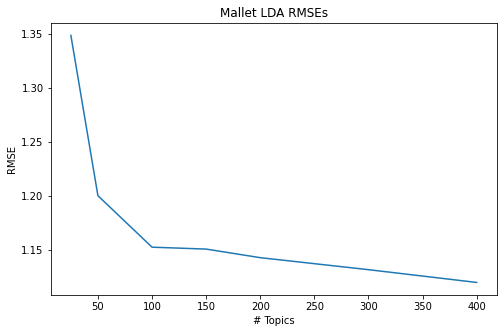

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
plt.plot(no_topics, mallet_lda_rmses)
plt.title("Mallet LDA RMSEs")
plt.xlabel("# Topics")
plt.ylabel("RMSE")
plt.show()

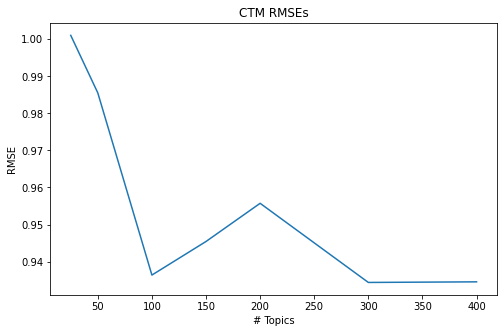

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
plt.plot(no_topics, ctm_rmses)
plt.title("CTM RMSEs")
plt.xlabel("# Topics")
plt.ylabel("RMSE")
plt.show()

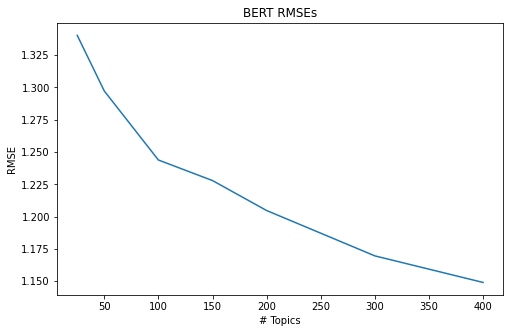

In [97]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
plt.plot(no_topics, bert_rmses)
plt.title("BERT RMSEs")
plt.xlabel("# Topics")
plt.ylabel("RMSE")
plt.show()

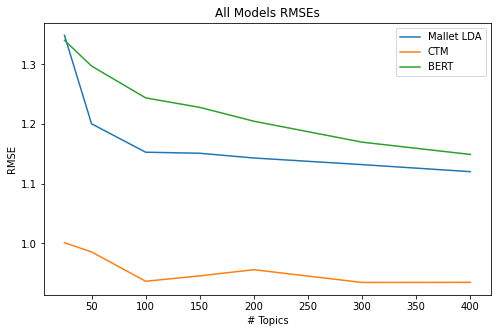

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
plt.plot(no_topics, mallet_lda_rmses)
plt.plot(no_topics, ctm_rmses)
plt.plot(no_topics, bert_rmses)
plt.legend(['Mallet LDA', 'CTM', 'BERT'])
plt.title("All Models RMSEs")
plt.xlabel("# Topics")
plt.ylabel("RMSE")
plt.show()